In [45]:
import json
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer

from gensim.models import Word2Vec
import pickle
from vae_util import Util as VaeUtil
from baseline_util import Util as BaselineUtil
from vae import VAE
from baseline import Baseline

In [46]:
util = VaeUtil()

Loaded Util


In [47]:
yelp_total_epoch_losses_vae = pickle.load(open("results-vae/yelp_total_epoch_losses_vae.pkl", "rb"))
yelp_total_kl_losses_vae = pickle.load(open("results-vae/yelp_total_kl_losses_vae.pkl", "rb"))
yelp_total_mi_vae = pickle.load(open("results-vae/yelp_total_mi_vae.pkl", "rb"))

yelp_val_total_epoch_losses_vae = pickle.load(open("results-vae/yelp_val_total_epoch_losses_vae.pkl", "rb"))
yelp_val_total_kl_losses_vae = pickle.load(open("results-vae/yelp_val_total_kl_losses_vae.pkl", "rb"))
yelp_val_total_mi_vae = pickle.load(open("results-vae/yelp_val_total_mi_vae.pkl", "rb"))

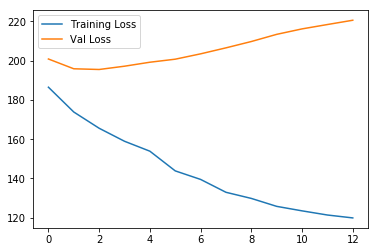

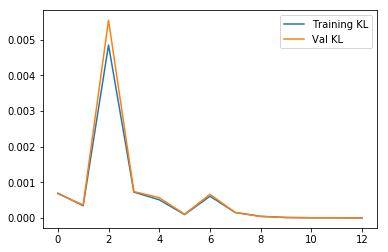

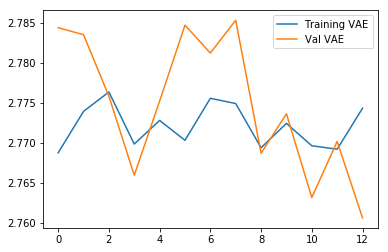

Loaded Util


In [48]:
plt.plot(yelp_total_epoch_losses_vae, label="Training Loss")
plt.plot(yelp_val_total_epoch_losses_vae, label="Val Loss")
plt.legend()
plt.show()

plt.plot(yelp_total_kl_losses_vae, label="Training KL")
plt.plot(yelp_val_total_kl_losses_vae, label="Val KL")
plt.legend()
plt.show()

plt.plot(yelp_total_mi_vae, label="Training VAE")
plt.plot(yelp_val_total_mi_vae, label="Val VAE")
plt.legend()
plt.show()


device = torch.device('cpu')
util = Util()

embedding_size = 512
word2vec_model_name = "word2vec_yelp.model"
word2vec_yelp = Word2Vec.load(word2vec_model_name)
embedding_weights = word2vec_yelp.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights, device=device)

batch_size = 16
vocabulary_size = len(word2vec_yelp.wv.vocab)
padding_index = vocabulary_size
hidden_size = 1024
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 2
max_sentence_length = 50

In [49]:
model = VAE(hidden_size, num_layers, embedding_weights, latent_size, max_sentence_length, device, synthetic=True).to(device)
model.load_state_dict(torch.load("results-vae/yelp-vae.pwf"))
model.eval()

VAE(
  (encoder): Encoder(
    (embed): Embedding(19840, 512)
    (lstm): LSTM(512, 1024, batch_first=True)
  )
  (stochastic_encoder): StochasticEncoder(
    (hidden_to_mean): Linear(in_features=2048, out_features=1, bias=True)
    (hidden_to_logvar): Linear(in_features=2048, out_features=1, bias=True)
  )
  (stochastic_decoder): StochasticDecoder(
    (latent_to_hidden): Linear(in_features=1, out_features=2048, bias=True)
  )
  (decoder): Decoder(
    (embed): Embedding(19840, 512)
    (lstm): LSTM(512, 1024, batch_first=True)
    (linear): Linear(in_features=1024, out_features=19840, bias=True)
  )
)

In [50]:
yelp_test_data_original, yelp_test_data_padded = util.load_data("yelp_data/yelp.test.txt", max_sentence_length, with_labels=True)

In [51]:
yelp_test_inputs, yelp_test_targets, yelp_test_lengths = \
                util.get_batches_text(yelp_test_data_original, yelp_test_data_padded, batch_size, padding_index, word2vec_yelp, '_unk')

In [52]:
loss, kl, ppl, mutual_info = util.test_vae(model, yelp_test_inputs[:10], yelp_test_targets[:10], yelp_test_lengths[:10], padding_index, max_sentence_length, device=device)

In [53]:
print(loss, kl, ppl, mutual_info)

315.9854347804561 3.872253000736237e-06 5.488075017024419e+28 2.7462416172027586


In [54]:
# Annealing latent size 1 YELP
yelp_total_epoch_losses_vae_anneal = pickle.load(open("results-vae-anneal/yelp_total_epoch_losses_vae_anneal.pkl", "rb"))
yelp_total_kl_losses_vae_anneal = pickle.load(open("results-vae-anneal/yelp_total_kl_losses_vae_anneal.pkl", "rb"))
yelp_total_mi_vae_anneal = pickle.load(open("results-vae-anneal/yelp_total_mi_vae_anneal.pkl", "rb"))

yelp_val_total_epoch_losses_vae_anneal = pickle.load(open("results-vae-anneal/yelp_val_total_epoch_losses_vae_anneal.pkl", "rb"))
yelp_val_total_kl_losses_vae_anneal = pickle.load(open("results-vae-anneal/yelp_val_total_kl_losses_vae_anneal.pkl", "rb"))
yelp_val_total_mi_vae_anneal = pickle.load(open("results-vae-anneal/yelp_val_total_mi_vae_anneal.pkl", "rb"))

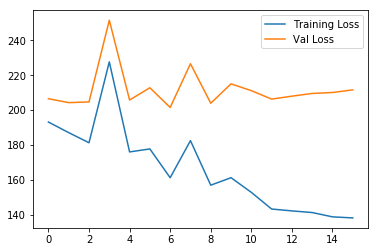

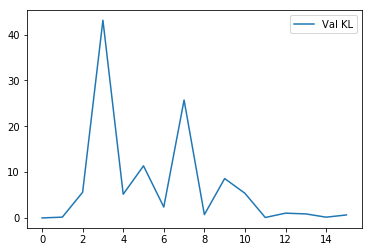

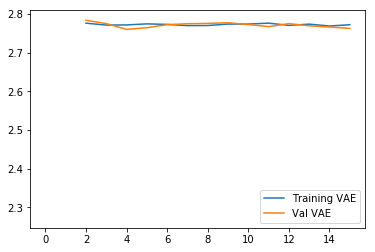

Loaded Util


In [55]:
plt.plot(yelp_total_epoch_losses_vae_anneal, label="Training Loss")
plt.plot(yelp_val_total_epoch_losses_vae_anneal, label="Val Loss")
plt.legend()
plt.show()

#plt.plot(yelp_total_kl_losses_vae_anneal, label="Training KL")
plt.plot(yelp_val_total_kl_losses_vae_anneal, label="Val KL")
plt.legend()
plt.show()

plt.plot(yelp_total_mi_vae_anneal, label="Training VAE")
plt.plot(yelp_val_total_mi_vae_anneal, label="Val VAE")
plt.legend()
plt.show()


device = torch.device('cpu')
util = Util()

embedding_size = 512
word2vec_model_name = "word2vec_yelp.model"
word2vec_yelp = Word2Vec.load(word2vec_model_name)
embedding_weights = word2vec_yelp.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights, device=device)

batch_size = 16
vocabulary_size = len(word2vec_yelp.wv.vocab)
padding_index = vocabulary_size
hidden_size = 1024
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 2
max_sentence_length = 50

In [13]:
loss, kl, ppl, mutual_info = util.test_vae(model, yelp_test_inputs, yelp_test_targets, yelp_test_lengths, padding_index, max_sentence_length, device=device)

KeyboardInterrupt: 

In [25]:
# Baseline YELP
yelp_total_epoch_losses_baseline = pickle.load(open("results-baseline/yelp_total_epoch_losses_baseline.pkl", "rb"))

yelp_val_total_epoch_losses_baseline = pickle.load(open("results-baseline/yelp_val_total_epoch_losses_baseline.pkl", "rb"))

Loaded Util


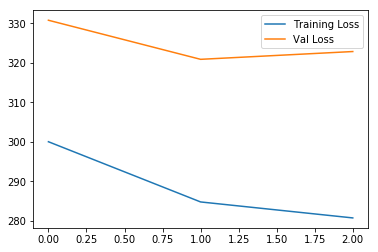

In [29]:
baselineUtil = BaselineUtil(device)
plt.plot(yelp_total_epoch_losses_baseline, label="Training Loss")
plt.plot(yelp_val_total_epoch_losses_baseline, label="Val Loss")
plt.legend()
plt.show()

In [32]:
hidden_size = 1024
num_layers = 1
learning_rate = 0.001
epochs = 3

In [34]:
model = Baseline(hidden_size, num_layers, embedding_weights, max_sentence_length, device, synthetic=True).to(device)
model.load_state_dict(torch.load("results-baseline/yelp-baseline.pwf"))
model.eval()

Baseline(
  (encoder): Encoder(
    (embed): Embedding(19840, 512)
    (lstm): LSTM(512, 1024, batch_first=True)
  )
  (decoder): Decoder(
    (embed): Embedding(19840, 512)
    (lstm): LSTM(512, 1024, batch_first=True)
    (linear): Linear(in_features=1024, out_features=19840, bias=True)
  )
)

In [41]:
loss, ppl = baselineUtil.test_baseline(model, yelp_test_inputs[:10], yelp_test_targets[:10], yelp_test_lengths[:10], padding_index, max_sentence_length)

In [42]:
print(loss, kl, ppl, mutual_info)

326.3473388671875 3.872253000736237e-06 780.667851181055 2.801023006439209
